In [50]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
import string
import matplotlib.pyplot as plt
from typing import Counter
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from NBClassifier import NBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

Lấy dữ liệu từ file csv

In [33]:
df = pd.read_csv('1kEmails.csv')
df.columns = ['Label', 'Mail']

print(df.shape)
df.head()


(1203, 2)


,Label,Mail
0,0,job posting - apple-iss research center conten...
1,0,"lang classification grimes , joseph e . and b..."
2,0,query : letter frequencies for text identifica...
3,0,risk a colleague and i are researching the dif...
4,0,request book information earlier this morning ...


Loại bỏ các mail trùng lặp

In [34]:
df.drop_duplicates(inplace = True)
print(df.shape)

(1190, 2)


Tách dataframe thành 2 tập train và test

In [35]:
randomized = df.sample(frac=1, random_state = 1)
train_size = round(len(randomized) * 0.8)
train = randomized[:train_size].reset_index(drop=True)
test = randomized[train_size:].reset_index(drop=True)
print(train.shape)
print(test.shape)

(952, 2)
(238, 2)


Hàm tiền xử lý dữ liệu bao gồm: xóa các đường dẫn, xóa dấu câu, xóa các stopword

In [48]:
def process_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    text = [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]
    
    return text

print(process_text("Dear Voucher Holder, To claim this weeks offer, at you PC please go to http://www.e-tlp.co.uk/expressoffer Ts&Cs apply. To stop texts, txt STOP to 80062"))

['dear', 'voucher', 'holder', 'claim', 'weeks', 'offer', 'pc', 'please', 'go', 'tscs', 'apply', 'stop', 'texts', 'txt', 'stop', '80062']


Tiền xử lý dữ liệu

In [37]:
bag_word = []
testmails= test['Mail']
test_labels = test['Label']
testmails2 = []
trainmails = train['Mail']
train_labels = train['Label']
trainmails2= []

testmails = testmails.apply(process_text)
trainmails = trainmails.apply(process_text)

In bag of word của tập train

33571


(-0.5, 1199.5, 799.5, -0.5)

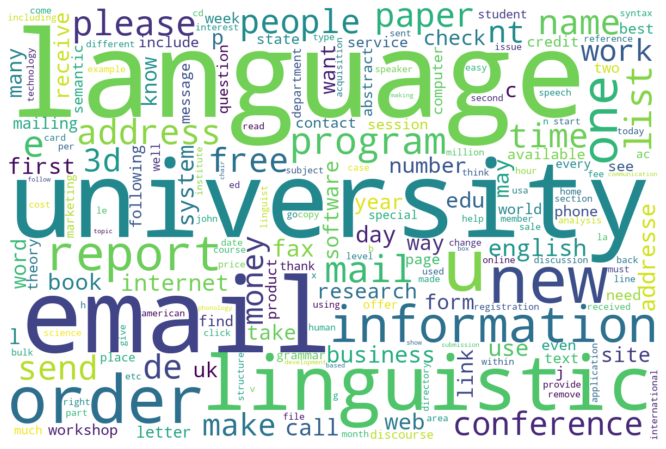

In [123]:
text = ""

for message in trainmails:
    text = text + " ".join(message) + " "
text1 = text.split()
text1 = set(text1)
print(len(text1))
wordcloud = WordCloud(width=1200,height=800,collocations = False,background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

In bag of word của tập train (không phải thư rác)

28023


(-0.5, 1199.5, 799.5, -0.5)

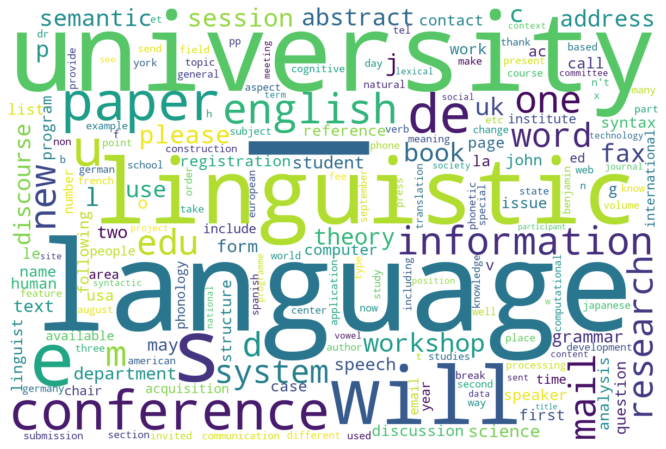

In [124]:
text = ""

for message in train[train.Label == 0].Mail:
    words = message.split()
    text = text + " ".join(words) + " "
text1 = text.split()
text1 = set(text1)
print(len(text1))
wordcloud = WordCloud(width=1200,height=800,collocations = False,background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

In bag of word của tập train (thư rác)

11505


(-0.5, 1199.5, 799.5, -0.5)

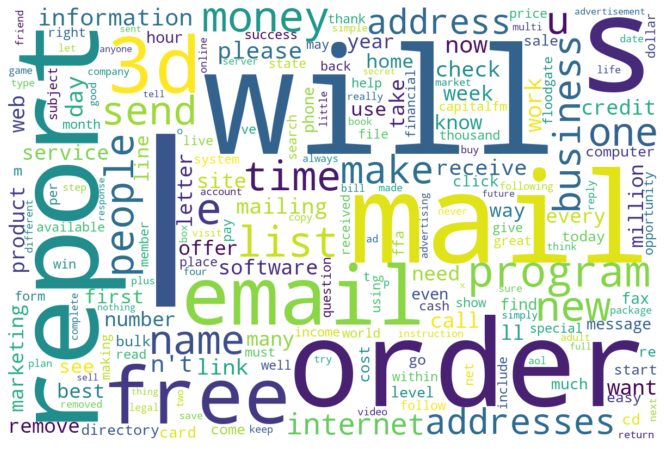

In [125]:
text = ""

for message in train[train.Label == 1].Mail:
    words = message.split()
    text = text + " ".join(words) + " "
text1 = text.split()
text1 = set(text1)
print(len(text1))
wordcloud = WordCloud(width=1200,height=800,collocations = False,background_color='white').generate(text)

plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')

Vector hóa tập train và test sau tiền xử lý

In [38]:
for doc in trainmails:
    words = doc
    bag_word += words

bag_word = set(bag_word)
bag_word = list(bag_word)

def tovector(mail):   
    splitmail = mail
    mvec = np.zeros(len(bag_word))
    count = Counter(splitmail)
    for i, word in enumerate(bag_word):
                mvec[i]+=count[word]
    
    return mvec

for i,mail in enumerate(testmails):

    testmails2.append(tovector(mail))

for i,mail in enumerate(trainmails):

    trainmails2.append(tovector(mail))

d = {'Mail': trainmails2, 'Label': train_labels}
Trainingdata = pd.DataFrame(data=d)
d = {'Mail': testmails2, 'Label': test_labels}
Testdata = pd.DataFrame(data=d)



Lọc thư rác bằng mô hình Naive Bayes (không dùng thư viện)

In [39]:
model= NBClassifier()
model.fit(Trainingdata['Mail'],Trainingdata['Label'])
result = model.predict(Testdata)

model.score(Testdata)

0.9873949579831933

In [40]:
trainingmails = list(Trainingdata['Mail'])
traininglabels= list(Trainingdata['Label'])
testmails=list(Testdata['Mail'])
testlabels= list(Testdata['Label'])

Lọc thư rác bằng mô hình Naive Bayes (có dùng thư viện)

In [41]:
model1 = MultinomialNB()
model1.fit(trainingmails,traininglabels)
result1 = model1.predict(testmails)
model1.score(testmails,testlabels)

0.9873949579831933

Lọc thư rác bằng mô hình Logistic Regression

In [42]:
model2 = LogisticRegression()
model2.fit(trainingmails,traininglabels)
result2 = model2.predict(testmails)
model2.score(testmails,testlabels)

0.9831932773109243

Lọc thư rác bằng mô hình SVC

In [43]:
model3 = SVC(kernel = 'linear')
model3.fit(trainingmails,traininglabels)
result3 = model3.predict(testmails)
model3.score(testmails,testlabels)

0.9831932773109243

Lọc thư rác bằng mô hình Random Forest

In [44]:
model4=RandomForestClassifier(n_estimators=100)
model4.fit(trainingmails,traininglabels)
result4 = model4.predict(testmails)
model4.score(testmails,testlabels)

0.9873949579831933